✓ Tutte le dipendenze installate!
✓ Librerie importate!

🎯 Pronto per iniziare!
Carica il file blackjack_simulator.csv:


Saving blackjack_simulator.csv to blackjack_simulator.csv

✓ Dataset caricato: 1000000 righe, 12 colonne

Prime righe:


,shoe_id,cards_remaining,dealer_up,initial_hand,dealer_final,dealer_final_value,player_final,player_final_value,actions_taken,run_count,true_count,win
0,0,416,5,"[10, 11]","[5, 2, 10]",17,"[[10, 11]]",['BJ'],[['S']],1,0,1.5
1,0,411,6,"[9, 6]","[6, 7, 11, 9]",23,"[[9, 6]]",[15],[['S']],0,0,1.0
2,0,405,11,"[10, 10]","[11, 4, 6]",21,"[[10, 10]]",[20],"[['N', 'S']]",1,0,-1.0
3,0,400,10,"[3, 9]","[10, 10]",20,"[[3, 9, 9]]",[21],"[['H', 'S']]",0,0,1.0
4,0,395,10,"[10, 5]","[10, 8]",18,"[[10, 5]]",[15],[['R']],-1,0,-0.5


 PIPELINE 1A: DECISION TREE

1. Preparazione dati...
✓ Dataset preparato: (1000000, 5)
  Distribuzione target: {1: 506008, 0: 493992}

2. Split dati...
✓ Train: 700000, Val: 100000, Test: 200000

3. Training Decision Tree...
✓ Decision Tree completato
  Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
  F1-Score Test: 0.6627
  Accuracy:  0.6871
  Precision:  0.7291
  Recall:  0.6073


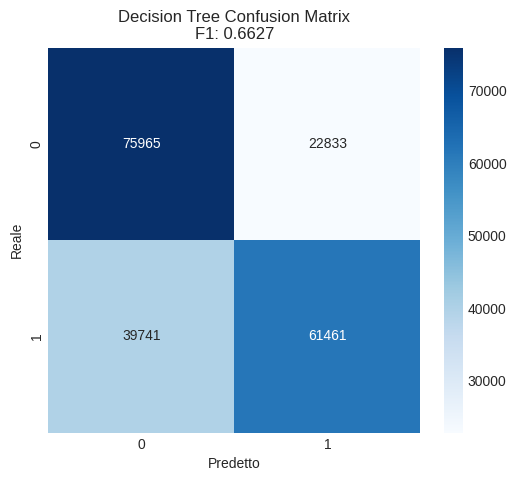


✅ PIPELINE 1 COMPLETATA!


In [2]:
# Pipeline 1A - Decision Tree
# Installazione dipendenze
!pip install -q pandas numpy scikit-learn matplotlib seaborn joblib tqdm imbalanced-learn xgboost

print("✓ Tutte le dipendenze installate!")

# Import base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configura visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Librerie importate!")
print("\n🎯 Pronto per iniziare!")

from google.colab import files

print("Carica il file blackjack_simulator.csv:")
uploaded = files.upload()

# Verifica upload
if 'blackjack_simulator.csv' in uploaded:
    df = pd.read_csv('blackjack_simulator.csv')
    print(f"\n✓ Dataset caricato: {df.shape[0]} righe, {df.shape[1]} colonne")
    print("\nPrime righe:")
    display(df.head())
else:
    print("⚠ File non trovato. Assicurati di caricare 'blackjack_simulator.csv'")

import ast
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import joblib

print("=" * 80)
print(" PIPELINE 1A: DECISION TREE")
print("=" * 80)

# === DATA PREPARATION ===
print("\n1. Preparazione dati...")
dataset = pd.read_csv('blackjack_simulator.csv')

# Discretizzazione target
condizioni = [
    (dataset['win'] > 0),
    (dataset['win'] == 0),
    (dataset['win'] < 0)
]
valori_target = [1, 0, -1]
dataset['win'] = np.select(condizioni, valori_target)

# Rimozione colonne
to_drop = [
    "shoe_id", "dealer_final", "dealer_final_value",
    "player_final", "player_final_value", "actions_taken",
    "run_count", "true_count", "cards_remaining"
]
dataset = dataset.drop(columns=to_drop, errors="ignore")

# Funzioni helper
def parse_hand(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            return parsed if isinstance(parsed, list) else []
        except: return []
    return []

def card_value(card):
    if isinstance(card, (int, float)): return int(card)
    c = str(card).strip().upper()
    if c in {"J", "Q", "K"}: return 10
    if c == "A": return 11
    try: return int(c)
    except: return 0

def hand_value_and_soft(hand):
    values = []
    aces_total = 0
    for c in hand:
        if str(c).strip().upper() == "A": aces_total += 1
        values.append(card_value(c))
    total = sum(values)
    aces_left = aces_total
    while total > 21 and aces_left > 0:
        total -= 10
        aces_left -= 1
    is_soft = 1 if aces_left < aces_total else 0
    return total, is_soft

# Feature engineering
dataset["initial_hand"] = dataset["initial_hand"].apply(parse_hand)
tmp = dataset["initial_hand"].apply(
    lambda h: hand_value_and_soft(h) if isinstance(h, list) else (0, 0)
)
dataset["player_sum"] = tmp.apply(lambda x: x[0]).astype(int)
dataset["player_is_soft"] = tmp.apply(lambda x: x[1]).astype(int)
dataset["player_pair"] = dataset["initial_hand"].apply(
    lambda h: 1 if isinstance(h, list) and len(h) == 2 and card_value(h[0]) == card_value(h[1]) else 0
).astype(int)
dataset["dealer_up"] = dataset["dealer_up"].apply(card_value).astype(int)

# Target binario
dataset["win_bin"] = (dataset["win"] >= 0).astype(int)

dataset_finale = dataset[
    ["player_sum", "player_is_soft", "player_pair", "dealer_up", "win_bin"]
].copy()

print(f"✓ Dataset preparato: {dataset_finale.shape}")
print(f"  Distribuzione target: {dataset_finale['win_bin'].value_counts().to_dict()}")

# === SPLIT DATI ===
print("\n2. Split dati...")
X = dataset_finale[["player_sum", "player_is_soft", "player_pair", "dealer_up"]]
y = dataset_finale["win_bin"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp
)

print(f"✓ Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# === DECISION TREE ===
print("\n3. Training Decision Tree...")
param_grid_dt = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_dt.fit(X_train, y_train)


best_dt = grid_dt.best_estimator_
y_test_pred_dt = best_dt.predict(X_test)
f1_dt = f1_score(y_test, y_test_pred_dt)
acc = accuracy_score(y_test, y_test_pred_dt)
rec = recall_score(y_test, y_test_pred_dt)
pre = precision_score(y_test, y_test_pred_dt)

print(f"✓ Decision Tree completato")
print(f"  Best params: {grid_dt.best_params_}")
print(f"  F1-Score Test: {f1_dt:.4f}")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision:  {pre:.4f}")
print(f"  Recall:  {rec:.4f}")


# Visualizzazione (Solo 1 grafico)
plt.figure(figsize=(6, 5))
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title(f'Decision Tree Confusion Matrix\nF1: {f1_dt:.4f}')
plt.ylabel('Reale')
plt.xlabel('Predetto')
plt.show()

print("\n" + "=" * 80)
print("✅ PIPELINE 1 COMPLETATA!")
print("=" * 80)
